In [2]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

import soundtools as st
import Kwik as oe
from file_tools import experiment as et
from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.basic_plot import plot_raster, sparse_raster
from basic_viewing import basic_plot as bp
from phy_tools import kwik_functions as kwf


Computer: txori


In [2]:
#file structure
bird_id = 'z020'
sess = '2016-06-02_11-10-42_2100'
rec = 'a'
run = 1
processor = '100'

raw_file_folder = os.path.join(raw_data_folder, bird_id, sess)
raw_file_base_name = 'experiment' + str(run)

raw_file_name = raw_file_base_name + '_' + processor + '.raw.kwd'
evt_file_name = raw_file_base_name + '.kwe'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
evt_file_path = os.path.join(raw_file_folder, evt_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')
evt_file = h5py.File(evt_file_path, 'r')

# load it with the open-ephys api for version 2 of kiwk format

oe_file = oe.load(raw_file_path)
channel_config = {'neural': [0, 11, 9, 16, 14, 5, 8, 10, 15, 2, 7, 4, 3, 5, 1, 16, 15],
                  '0' : [11, 15, 8, 10],
                  '1' : [14, 9, 13, 12],
                  '2' : [2, 3, 1, 6],
                  '3' : [5, 7, 0, 4], 
                  'test' : [11],
                 'sound': [17]}

In [3]:
#given a chunk that contains a sine wave, find its onset
def peaks(signal, min_height=0):
    np.where(signal[1:-1]>min_height)
    peak_ind = [i for i in np.where(signal[1:-1]>min_height)[0] if signal[i]>signal[i-1] & signal[i]>signal[i+1]]
    return peak_ind

def find_onset_sine(chunk, freq=1000, f_s=30000):
    roof = int(max(chunk)*0.25)
    first_peak = peaks(chunk, min_height=roof)[0]
    
    onset = first_peak - int(f_s/(4.*freq))
    return onset

In [5]:
bout_starts_s = [3674.214226,
                 5440.417182,
                 5440.931701,
                 5441.436431,
                 5441.937063,
                 5442.929469,
                 5444.768863,
                 3677.666521]
                 
inc_bout_starts = [5441.402442,
                   5443.408628,
                   5443.814313,
                   5425.276764,
                   5445.283357,
                   3674.734087,
                   3675.104892,
                   3675.615050,
                   3676.133218,
                   3676.509485,
                   3676.984166,
                   3678.181699]
                 
                 

In [8]:
# get a chunk of the h5 file:
table = oe_file['data']

neural_chans = np.array((channel_config['0']))
s_f = oe.get_sample_rate(raw_file)

start_s = 3674.215477-0.5
end_s = start_s + 1.
start_sample = int(start_s*s_f)
end_sample = int(end_s*s_f)
first_neural = np.min(neural_chans)
last_neural = np.max(neural_chans)

(<matplotlib.figure.Figure at 0x7f8e2c082a10>,
 <matplotlib.axes._axes.Axes at 0x7f8d92f8de50>)

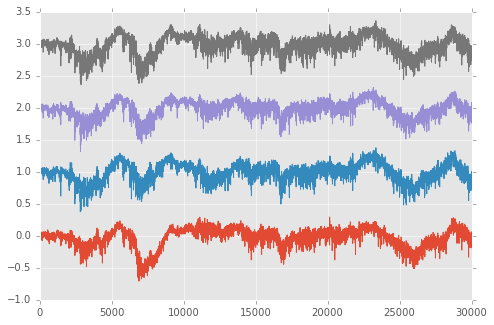

In [9]:
#table_slice = np.zeros([end_sample-start_sample, last_neural - first_neural])
#table.read_direct(table_slice, np.s_[start_sample:end_sample, first_neural:last_neural])
table_slice = h5.load_table_slice(table, np.arange(start_sample, end_sample), neural_chans)
bout_data = st.DatSound(table_slice, s_f)
bout_frame = st.Chunk(bout_data, chan_list=np.arange(0, table_slice.shape[1]))
bout_frame.plot()

In [ ]:
class H5Data:
    def __init__(self, h5_table, s_f):
        self.data_type = np.dtype(a_dset.dtype)
        self.s_f = s_f
        self.n_chans = h5_table.shape[h5_table.ndim-1]
        self.n_samples = int(h5_table.size/h5_table.shape[h5_table.ndim-1])
        self.table = h5_table

    def get_chunk(self, start, end, chan_list=[0]):
        assert (start >= 0)
        assert (end <= self.n_samples)
        assert (end > start)

        data = np.array(h5.load_table_slice(self.table, np.arange(start, end), chan_list),
                        dtype=self.data_type)
        return data

h5d = H5Data(a_dset, 30000.)

(<matplotlib.figure.Figure at 0x7f8e2c082f90>,
 <matplotlib.axes._axes.Axes at 0x7f8d92c5a8d0>)

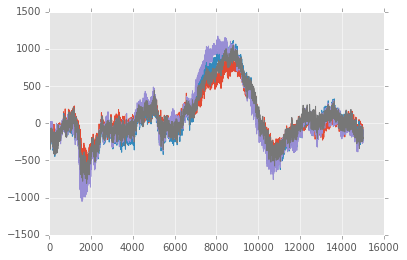

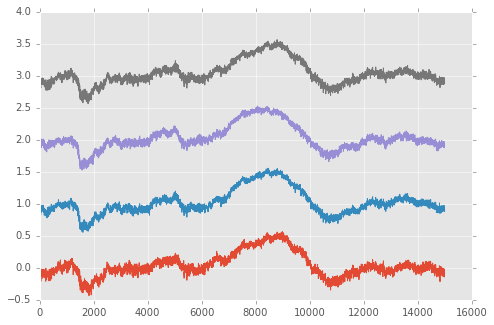

In [10]:
samples_after = 0.5 * s_f
samples_before = 0.

starting_points = bout_starts_s + inc_bout_starts

lfp_stack = np.zeros([int(samples_before + samples_after), neural_chans.size, np.array(starting_points).size])

for i, start_sec in enumerate(starting_points):
    start_sample = int(start_sec*s_f - samples_before)
    end_sample = int(start_sample + samples_after)
    lfp_stack[:,:, i]= h5.load_table_slice(table, np.arange(start_sample, end_sample), neural_chans)
    
mean_lfp = lfp_stack.sum(2)/lfp_stack.shape[2]
plt.plot(mean_lfp)
mean_lfp_data = st.DatSound(mean_lfp, s_f)
mean_lfp_data_frame = st.Chunk(mean_lfp_data, chan_list=np.arange(0, mean_lfp.shape[1]))
mean_lfp_data_frame.plot()

(<matplotlib.figure.Figure at 0x7f8d92b6dd50>,
 <matplotlib.axes._axes.Axes at 0x7f8d8ffffa10>)

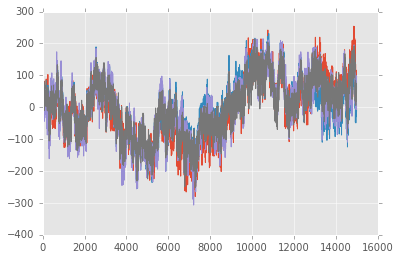

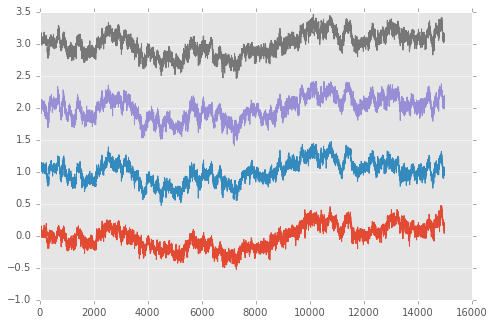

In [11]:
samples_after = 0.5 * s_f
samples_before = 0.

starting_points = bout_starts_s + inc_bout_starts

lfp_stack = np.zeros([int(samples_before + samples_after), neural_chans.size, np.array(starting_points).size])

for i, start_sec in enumerate(starting_points):
    start_sample = int(start_sec*s_f - samples_before) + 1000*30000
    end_sample = int(start_sample + samples_after)
    lfp_stack[:,:, i]= h5.load_table_slice(table, np.arange(start_sample, end_sample), neural_chans)
    
mean_lfp = lfp_stack.sum(2)/lfp_stack.shape[2]
plt.plot(mean_lfp)
mean_lfp_data = st.DatSound(mean_lfp, s_f)
mean_lfp_data_frame = st.Chunk(mean_lfp_data, chan_list=np.arange(0, mean_lfp.shape[1]))
mean_lfp_data_frame.plot()

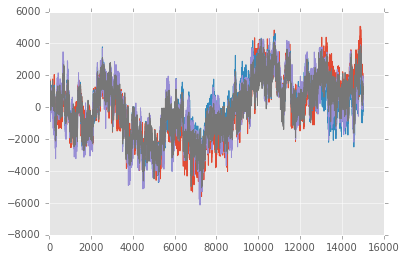

In [12]:
plt.plot(lfp_stack.sum(2))

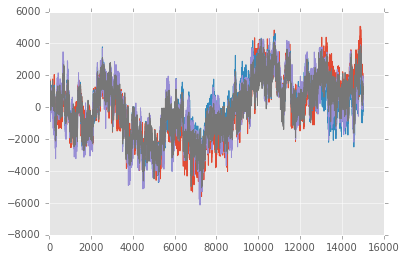

In [13]:
plt.plot(lfp_stack.sum(2))

In [59]:
def load_table_slice(table, row_list=None, col_list=None):
    table_cols = table.shape[1]
    table_rows = table.shape[0]

    col_list = np.arange(table_cols) if col_list is None else np.array(col_list)
    row_list = np.arange(table_rows) if row_list is None else np.array(row_list)

    raw_table_slice = np.zeros([np.ptp(row_list)+1, np.ptp(col_list)+1])
    #print raw_table_slice.shape
    table.read_direct(raw_table_slice, np.s_[np.min(row_list): np.max(row_list)+1, np.min(col_list): np.max(col_list)+1])
    #return raw_table_slice
    #print col_list - np.min(col_list)
    return raw_table_slice[row_list - np.min(row_list), :][:, col_list - np.min(col_list)]

rts = load_table_slice(table, np.arange(start_sample, end_sample), neural_chans)

In [52]:
start_sample

8500710000

In [39]:
table_slice[np.arange(5,10)-5, :][:, np.array([0, 2, 3])]

array([[ 262.,  136.,  176.],
       [ 169.,  115.,  222.],
       [ 186.,  115.,  239.],
       [ 253.,  107.,  204.],
       [ 234.,  127.,  144.]])

<Attributes of HDF5 object at 140246028460912>

In [28]:
table.shape[0]/table.chunks[0]

337387

In [ ]:
# neural dataset
f.close()
channel_config['neural']
nd_file_name = raw_file_name + 'neural'
nd_file_path = os.path.join(raw_data_folder, nd_file_name)

f = h5py.File(nd_file_path, 'w')
raw_file.copy('/recordings', f['/'])

In [70]:
def neural_kwik_file(data_kwik_file, full_path):
    f = h5py.File(full_path, 'w')
    
    
def neural_data_set(data_set, channel_list, parent_group, frame_size=None, processing=None, *args, **kwargs):
    # make the new dataset
    d_type = data_set.dtype
    nd_cols = np.array(channel_list).size
    nd_rows = data_set.shape[0]
    d_chunks = data_set.chunks
    
    if frame_size is None:
        frame_size = d_chunks[0]
    
    neural_dset = parent_group.create_dataset("chunked", (nd_rows, nd_cols), 
                                              chunks=(d_chunks[0], nd_cols))
    
    copy_frame = np.zeros([frame_size, nd_cols], dtype=d_type)
    n_full_frames = data_set.shape[0]/frame_size
    #print neural_dset.shape
    # Fill the dataset:
    for i in range(2):
        copy_frame = h5.load_table_slice(data_set, np.arange(i*frame_size, (i+1)*frame_size) , channel_list)
        #print copy_frame.shape
        #neural_dset.write_direct(copy_frame, dest_sel=np.s_[i*frame_size: (i+1)*frame_size, 0:nd_cols])
        neural_dset[i*frame_size: (i+1)*frame_size, 0:nd_cols] = copy_frame

#f.close()
f = h5py.File(nd_file_path, 'w')
f.create_group('/recordings')
f.create_group('/recordings/0')
neural_data_set(table, channel_config['0'], f['/recordings/0'])
f.close()

In [54]:
f.close()
f = h5py.File(nd_file_path, 'w')
f.create_group('/recordings')
f.create_group('/recordings/0')
neural_data_set(table, channel_config['0'], f['/recordings/0'])

NameError: global name 'load_table_slice' is not defined

In [67]:
channel_config['neural']
nd_file_name = raw_file_name + 'neural'
nd_file_path = os.path.join(raw_file_folder, nd_file_name)

f = h5py.File(nd_file_path, 'w')

In [69]:
nd_file_path

'/mnt/cube/earneodo/bci_zf/raw_data/z020/2016-06-02_11-10-42_2100/experiment1_100.raw.kwdneural'

In [46]:
#f.close()
f = h5py.File(nd_file_path, 'w')
f.create_group('/recordings')
f.create_group('/recordings/0')

<HDF5 group "/recordings/0" (0 members)>

In [47]:
f['/recordings/0']

<HDF5 group "/recordings/0" (0 members)>

In [76]:
table.attrs.keys()

[u'valid_samples']

In [ ]:
table.attrs.create